##### Copyright 2019 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# pix2pix：使用条件 GAN 进行图像到图像的转换

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://tensorflow.google.cn/tutorials/generative/pix2pix"><img src="https://tensorflow.google.cn/images/tf_logo_32px.png">在 TensorFlow.org 上查看</a> </td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/generative/pix2pix.ipynb"><img src="https://tensorflow.google.cn/images/colab_logo_32px.png">在 Google Colab 中运行 </a></td>
  <td>     <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/generative/pix2pix.ipynb"><img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png">在 GitHub 上查看源代码</a> </td>
  <td>     <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/tutorials/generative/pix2pix.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png">下载笔记本</a> </td>
</table>

本教程演示了如何构建和训练一个名为 pix2pix 的条件生成对抗网络 (cGAN)，该网络学习从输入图像到输出图像的映射，如 Isola 等人在 [Image-to-image translation with conditional adversarial networks](https://arxiv.org/abs/1611.07004){:.external} （2017 年）中所述 。pix2pix 非特定于应用，它可以应用于多种任务，包括从标签地图合成照片，从黑白图像生成彩色照片，将 Google Maps 照片转换为航拍图像，甚至将草图转换为照片。

在此示例中，您的网络将使用[布拉格捷克理工大学](http://cmp.felk.cvut.cz/~tylecr1/facade/){:.external}的[机器感知中心](http://cmp.felk.cvut.cz/){:.external}提供的 [CMP Facade Database](https://www.cvut.cz/) 来生成建筑立面。为了简化示例，您将使用由 pix2pix 作者创建的此数据集的[预处理副本](https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/){:.external}。

在 pix2pix cGAN 中，您可以对输入图像进行调节并生成相应的输出图像。cGAN 最初在 [Conditional Generative Adversarial Nets](https://arxiv.org/abs/1411.1784) (Mirza and Osindero, 2014) 中提出。

您的网络架构将包含：

- 基于 [U-Net](https://arxiv.org/abs/1505.04597){:.external} 架构的生成器。
- 由卷积 PatchGAN 分类器表示的判别器（在 [pix2pix 论文](https://arxiv.org/abs/1611.07004){:.external}中提出）。

请注意，在单个 V100 GPU 上，每个周期可能需要大约 15 秒。

以下是 pix2pix cGAN 在 Facade Database（8 万步）上训练 200 个周期后生成的一些输出示例。

![sample output_1](https://tensorflow.google.cn/images/gan/pix2pix_1.png) ![sample output_2](https://tensorflow.google.cn/images/gan/pix2pix_2.png)

## 导入 TensorFlow 和其他库

In [2]:
import tensorflow as tf

import os
import pathlib
import time
import datetime

from matplotlib import pyplot as plt
from IPython import display

2023-11-07 19:45:11.076259: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-07 19:45:11.076311: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-07 19:45:11.077813: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## 加载数据集

下载 CMP Facade Database 数据 (30MB)。可在[这里](http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/){:.external}以相同格式获得其他数据集。在 Colab 中，您可以从下拉菜单中选择其他数据集。请注意，其他一些数据集要大得多（`edges2handbags` 为 8GB）。 

In [3]:
dataset_name = "facades" #@param ["cityscapes", "edges2handbags", "edges2shoes", "facades", "maps", "night2day"]


In [4]:
_URL = f'http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/{dataset_name}.tar.gz'

path_to_zip = tf.keras.utils.get_file(
    fname=f"{dataset_name}.tar.gz",
    origin=_URL,
    extract=True)

path_to_zip  = pathlib.Path(path_to_zip)

PATH = path_to_zip.parent/dataset_name

    8192/30168306 [..............................] - ETA: 0s

   16384/30168306 [..............................] - ETA: 1:35

   49152/30168306 [..............................] - ETA: 1:05

   90112/30168306 [..............................] - ETA: 55s 

  180224/30168306 [..............................] - ETA: 38s

  278528/30168306 [..............................] - ETA: 1:35

  286720/30168306 [..............................] - ETA: 1:44

  385024/30168306 [..............................] - ETA: 1:24

  401408/30168306 [..............................] - ETA: 1:28

  417792/30168306 [..............................] - ETA: 1:31

  425984/30168306 [..............................] - ETA: 1:33

  450560/30168306 [..............................] - ETA: 1:31

  475136/30168306 [..............................] - ETA: 1:32

  499712/30168306 [..............................] - ETA: 1:31

  524288/30168306 [..............................] - ETA: 1:29

  548864/30168306 [..............................] - ETA: 1:28

  573440/30168306 [..............................] - ETA: 1:27

  606208/30168306 [..............................] - ETA: 1:24

  630784/30168306 [..............................] - ETA: 1:23

  663552/30168306 [..............................] - ETA: 1:21

  696320/30168306 [..............................] - ETA: 1:19

  720896/30168306 [..............................] - ETA: 1:19

  753664/30168306 [..............................] - ETA: 1:17

  794624/30168306 [..............................] - ETA: 1:15

  827392/30168306 [..............................] - ETA: 1:14

  860160/30168306 [..............................] - ETA: 1:13

  901120/30168306 [..............................] - ETA: 1:11

  942080/30168306 [..............................] - ETA: 1:09

  983040/30168306 [..............................] - ETA: 1:08

 1015808/30168306 [>.............................] - ETA: 1:07

 1064960/30168306 [>.............................] - ETA: 1:05

 1105920/30168306 [>.............................] - ETA: 1:04

 1146880/30168306 [>.............................] - ETA: 1:03

 1196032/30168306 [>.............................] - ETA: 1:01

 1245184/30168306 [>.............................] - ETA: 1:00

 1286144/30168306 [>.............................] - ETA: 59s 

 1343488/30168306 [>.............................] - ETA: 58s

 1392640/30168306 [>.............................] - ETA: 57s

 1441792/30168306 [>.............................] - ETA: 56s

 1499136/30168306 [>.............................] - ETA: 54s

 1556480/30168306 [>.............................] - ETA: 53s

 1613824/30168306 [>.............................] - ETA: 52s

 1671168/30168306 [>.............................] - ETA: 51s

 1728512/30168306 [>.............................] - ETA: 50s

 1794048/30168306 [>.............................] - ETA: 49s

 1851392/30168306 [>.............................] - ETA: 48s

 1916928/30168306 [>.............................] - ETA: 47s

 1982464/30168306 [>.............................] - ETA: 46s

 2048000/30168306 [=>............................] - ETA: 45s

 2121728/30168306 [=>............................] - ETA: 44s

 2195456/30168306 [=>............................] - ETA: 43s

 2269184/30168306 [=>............................] - ETA: 42s

 2342912/30168306 [=>............................] - ETA: 42s

 2424832/30168306 [=>............................] - ETA: 41s

 2506752/30168306 [=>............................] - ETA: 40s

 2596864/30168306 [=>............................] - ETA: 39s

 2678784/30168306 [=>............................] - ETA: 38s

 2719744/30168306 [=>............................] - ETA: 38s

 2809856/30168306 [=>............................] - ETA: 37s

 2899968/30168306 [=>............................] - ETA: 36s

 2998272/30168306 [=>............................] - ETA: 35s

 3096576/30168306 [==>...........................] - ETA: 35s

 3194880/30168306 [==>...........................] - ETA: 34s

 3301376/30168306 [==>...........................] - ETA: 33s

 3407872/30168306 [==>...........................] - ETA: 32s

 3514368/30168306 [==>...........................] - ETA: 32s

 3629056/30168306 [==>...........................] - ETA: 31s

 3743744/30168306 [==>...........................] - ETA: 30s

 3866624/30168306 [==>...........................] - ETA: 29s

 3981312/30168306 [==>...........................] - ETA: 29s

 4104192/30168306 [===>..........................] - ETA: 28s

 4227072/30168306 [===>..........................] - ETA: 27s

 4358144/30168306 [===>..........................] - ETA: 27s

 4489216/30168306 [===>..........................] - ETA: 26s

 4620288/30168306 [===>..........................] - ETA: 26s

 4759552/30168306 [===>..........................] - ETA: 25s

 4898816/30168306 [===>..........................] - ETA: 24s

 5046272/30168306 [====>.........................] - ETA: 24s

 5193728/30168306 [====>.........................] - ETA: 23s

 5349376/30168306 [====>.........................] - ETA: 23s

 5505024/30168306 [====>.........................] - ETA: 22s

 5627904/30168306 [====>.........................] - ETA: 22s

 5791744/30168306 [====>.........................] - ETA: 21s

 5906432/30168306 [====>.........................] - ETA: 21s

 6078464/30168306 [=====>........................] - ETA: 20s

 6250496/30168306 [=====>........................] - ETA: 20s

 6430720/30168306 [=====>........................] - ETA: 19s

 6610944/30168306 [=====>........................] - ETA: 19s

 6799360/30168306 [=====>........................] - ETA: 18s

 6995968/30168306 [=====>........................] - ETA: 18s

 7192576/30168306 [======>.......................] - ETA: 17s

 7397376/30168306 [======>.......................] - ETA: 17s

 7610368/30168306 [======>.......................] - ETA: 16s

 7815168/30168306 [======>.......................] - ETA: 16s

 8036352/30168306 [======>.......................] - ETA: 15s

 8257536/30168306 [=======>......................] - ETA: 15s

 8437760/30168306 [=======>......................] - ETA: 15s

 8593408/30168306 [=======>......................] - ETA: 14s

 8830976/30168306 [=======>......................] - ETA: 14s

 9076736/30168306 [========>.....................] - ETA: 14s

 9322496/30168306 [========>.....................] - ETA: 13s

 9576448/30168306 [========>.....................] - ETA: 13s

 9830400/30168306 [========>.....................] - ETA: 12s

10100736/30168306 [=========>....................] - ETA: 12s

10371072/30168306 [=========>....................] - ETA: 12s

10567680/30168306 [=========>....................] - ETA: 11s

10846208/30168306 [=========>....................] - ETA: 11s

11132928/30168306 [==========>...................] - ETA: 11s

11427840/30168306 [==========>...................] - ETA: 10s

11722752/30168306 [==========>...................] - ETA: 10s

12017664/30168306 [==========>...................] - ETA: 10s

12320768/30168306 [===========>..................] - ETA: 9s 

12640256/30168306 [===========>..................] - ETA: 9s

12959744/30168306 [===========>..................] - ETA: 9s

13295616/30168306 [============>.................] - ETA: 8s

13631488/30168306 [============>.................] - ETA: 8s

13967360/30168306 [============>.................] - ETA: 8s

14327808/30168306 [=============>................] - ETA: 7s

14639104/30168306 [=============>................] - ETA: 7s

14917632/30168306 [=============>................] - ETA: 7s

15286272/30168306 [==============>...............] - ETA: 7s

15663104/30168306 [==============>...............] - ETA: 6s

15966208/30168306 [==============>...............] - ETA: 6s

16351232/30168306 [===============>..............] - ETA: 6s

16687104/30168306 [===============>..............] - ETA: 6s

17022976/30168306 [===============>..............] - ETA: 5s

17334272/30168306 [================>.............] - ETA: 5s

17645568/30168306 [================>.............] - ETA: 5s

17653760/30168306 [================>.............] - ETA: 5s

17743872/30168306 [================>.............] - ETA: 5s

17842176/30168306 [================>.............] - ETA: 5s

17932288/30168306 [================>.............] - ETA: 5s

17940480/30168306 [================>.............] - ETA: 5s

18030592/30168306 [================>.............] - ETA: 5s

18120704/30168306 [=================>............] - ETA: 5s

18194432/30168306 [=================>............] - ETA: 5s

18268160/30168306 [=================>............] - ETA: 5s

18333696/30168306 [=================>............] - ETA: 5s

18407424/30168306 [=================>............] - ETA: 5s

18489344/30168306 [=================>............] - ETA: 5s

18563072/30168306 [=================>............] - ETA: 5s

18644992/30168306 [=================>............] - ETA: 5s

18718720/30168306 [=================>............] - ETA: 5s

18800640/30168306 [=================>............] - ETA: 5s

18882560/30168306 [=================>............] - ETA: 5s

18964480/30168306 [=================>............] - ETA: 5s

19054592/30168306 [=================>............] - ETA: 5s

19144704/30168306 [==================>...........] - ETA: 5s

19234816/30168306 [==================>...........] - ETA: 5s

19324928/30168306 [==================>...........] - ETA: 5s

19423232/30168306 [==================>...........] - ETA: 5s

19521536/30168306 [==================>...........] - ETA: 5s

19619840/30168306 [==================>...........] - ETA: 5s

19652608/30168306 [==================>...........] - ETA: 5s

19759104/30168306 [==================>...........] - ETA: 5s

19857408/30168306 [==================>...........] - ETA: 5s

19963904/30168306 [==================>...........] - ETA: 5s

20078592/30168306 [==================>...........] - ETA: 5s

20193280/30168306 [===================>..........] - ETA: 5s

20307968/30168306 [===================>..........] - ETA: 4s

20430848/30168306 [===================>..........] - ETA: 4s

20545536/30168306 [===================>..........] - ETA: 4s

20676608/30168306 [===================>..........] - ETA: 4s

20807680/30168306 [===================>..........] - ETA: 4s

20856832/30168306 [===================>..........] - ETA: 4s

20987904/30168306 [===================>..........] - ETA: 4s

21127168/30168306 [====================>.........] - ETA: 4s

21266432/30168306 [====================>.........] - ETA: 4s

21405696/30168306 [====================>.........] - ETA: 4s

21553152/30168306 [====================>.........] - ETA: 4s

21708800/30168306 [====================>.........] - ETA: 4s

21864448/30168306 [====================>.........] - ETA: 4s

22020096/30168306 [====================>.........] - ETA: 4s

22183936/30168306 [=====================>........] - ETA: 3s

22298624/30168306 [=====================>........] - ETA: 3s

22413312/30168306 [=====================>........] - ETA: 3s

22585344/30168306 [=====================>........] - ETA: 3s

22757376/30168306 [=====================>........] - ETA: 3s

22929408/30168306 [=====================>........] - ETA: 3s

23109632/30168306 [=====================>........] - ETA: 3s

23298048/30168306 [======================>.......] - ETA: 3s

23486464/30168306 [======================>.......] - ETA: 3s

23683072/30168306 [======================>.......] - ETA: 3s

23871488/30168306 [======================>.......] - ETA: 3s

24076288/30168306 [======================>.......] - ETA: 2s

24281088/30168306 [=======================>......] - ETA: 2s

24494080/30168306 [=======================>......] - ETA: 2s

24649728/30168306 [=======================>......] - ETA: 2s

24862720/30168306 [=======================>......] - ETA: 2s

25092096/30168306 [=======================>......] - ETA: 2s

25313280/30168306 [========================>.....] - ETA: 2s

25509888/30168306 [========================>.....] - ETA: 2s

25673728/30168306 [========================>.....] - ETA: 2s

25903104/30168306 [========================>.....] - ETA: 1s

26140672/30168306 [========================>.....] - ETA: 1s

26386432/30168306 [=========================>....] - ETA: 1s

26632192/30168306 [=========================>....] - ETA: 1s

26886144/30168306 [=========================>....] - ETA: 1s

27140096/30168306 [=========================>....] - ETA: 1s

27410432/30168306 [==========================>...] - ETA: 1s

27680768/30168306 [==========================>...] - ETA: 1s

27951104/30168306 [==========================>...] - ETA: 0s

28237824/30168306 [===========================>..] - ETA: 0s

28450816/30168306 [===========================>..] - ETA: 0s

28745728/30168306 [===========================>..] - ETA: 0s

29040640/30168306 [===========================>..] - ETA: 0s

29351936/30168306 [============================>.] - ETA: 0s

29663232/30168306 [============================>.] - ETA: 0s

29908992/30168306 [============================>.] - ETA: 0s

30168306/30168306 [==============================] - 13s 0us/step


In [5]:
list(PATH.parent.iterdir())

[PosixPath('/home/kbuilder/.keras/datasets/iris_training.csv'),
 PosixPath('/home/kbuilder/.keras/datasets/facades.tar.gz'),
 PosixPath('/home/kbuilder/.keras/datasets/facades'),
 PosixPath('/home/kbuilder/.keras/datasets/iris_test.csv'),
 PosixPath('/home/kbuilder/.keras/datasets/YellowLabradorLooking_new.jpg'),
 PosixPath('/home/kbuilder/.keras/datasets/kandinsky5.jpg'),
 PosixPath('/home/kbuilder/.keras/datasets/mnist.npz'),
 PosixPath('/home/kbuilder/.keras/datasets/fashion-mnist')]

每个原始图像的大小为 `256 x 512`，包含两个 `256 x 256` 图像：

In [6]:
sample_image = tf.io.read_file(str(PATH / 'train/1.jpg'))
sample_image = tf.io.decode_jpeg(sample_image)
print(sample_image.shape)

(256, 512, 3)


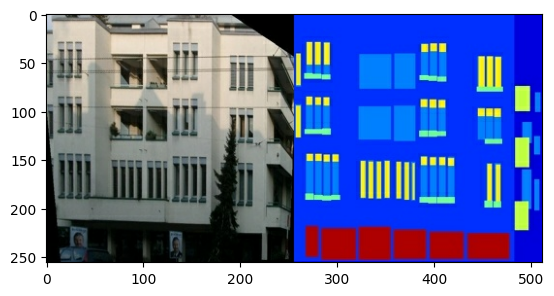

In [7]:
plt.figure()
plt.imshow(sample_image)

您需要将真实的建筑立面图像与建筑标签图像分开，所有这些图像的大小都是 `256 x 256`。

定义加载图像文件并输出两个图像张量的函数：

In [8]:
def load(image_file):
  # Read and decode an image file to a uint8 tensor
  image = tf.io.read_file(image_file)
  image = tf.io.decode_jpeg(image)

  # Split each image tensor into two tensors:
  # - one with a real building facade image
  # - one with an architecture label image 
  w = tf.shape(image)[1]
  w = w // 2
  input_image = image[:, w:, :]
  real_image = image[:, :w, :]

  # Convert both images to float32 tensors
  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image

绘制输入图像（建筑标签图像）和真实（建筑立面照片）图像的样本：

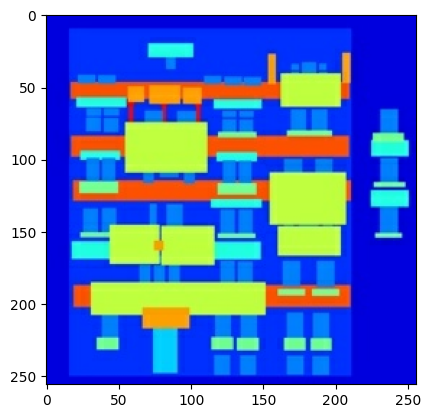

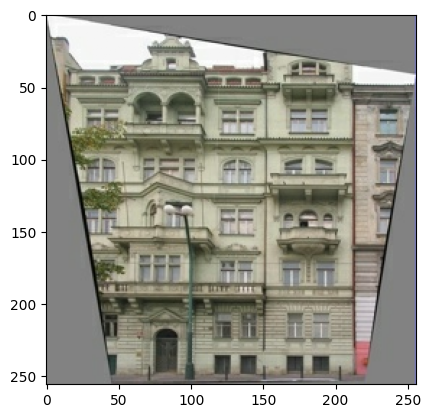

In [9]:
inp, re = load(str(PATH / 'train/100.jpg'))
# Casting to int for matplotlib to display the images
plt.figure()
plt.imshow(inp / 255.0)
plt.figure()
plt.imshow(re / 255.0)

如 [pix2pix 论文](https://arxiv.org/abs/1611.07004){:.external}中所述，您需要应用随机抖动和镜像来预处理训练集。

定义几个具有以下功能的函数：

1. 将每个 `256 x 256` 图像调整为更大的高度和宽度，`286 x 286`。
2. 将其随机裁剪回 `256 x 256`。
3. 随机水平翻转图像，即从左到右（随机镜像）。
4. 将图像归一化到 `[-1, 1]` 范围。

In [10]:
# The facade training set consist of 400 images
BUFFER_SIZE = 400
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1
# Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [11]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [12]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

In [13]:
# Normalizing the images to [-1, 1]
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [14]:
@tf.function()
def random_jitter(input_image, real_image):
  # Resizing to 286x286
  input_image, real_image = resize(input_image, real_image, 286, 286)

  # Random cropping back to 256x256
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # Random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

您可以检查部分预处理输出：

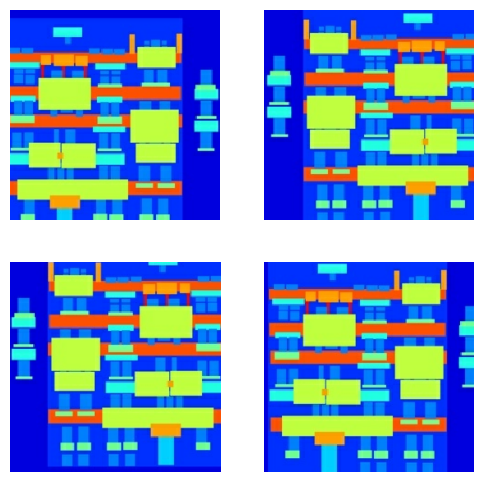

In [15]:
plt.figure(figsize=(6, 6))
for i in range(4):
  rj_inp, rj_re = random_jitter(inp, re)
  plt.subplot(2, 2, i + 1)
  plt.imshow(rj_inp / 255.0)
  plt.axis('off')
plt.show()

检查加载和预处理能够正常工作后，我们来定义两个辅助函数来加载和预处理训练集和测试集：

In [16]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [17]:
def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

## 使用 `tf.data` 构建输入流水线

In [18]:
train_dataset = tf.data.Dataset.list_files(str(PATH / 'train/*.jpg'))
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [19]:
try:
  test_dataset = tf.data.Dataset.list_files(str(PATH / 'test/*.jpg'))
except tf.errors.InvalidArgumentError:
  test_dataset = tf.data.Dataset.list_files(str(PATH / 'val/*.jpg'))
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

## 构建生成器

您的 pix2pix cGAN 是*经过修改的* [U-Net](https://arxiv.org/abs/1505.04597){:.external}。U-Net 由编码器（下采样器）和解码器（上采样器）。（有关详细信息，请参阅[图像分割](../images/segmentation.ipynb)教程和 [U-Net 项目网站](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/){:.external}。）

- 编码器中的每个块为：Convolution -&gt; Batch normalization -&gt; Leaky ReLU
- 解码器中的每个块为：Transposed convolution -&gt; Batch normalization -&gt; Dropout（应用于前三个块）-&gt; ReLU
- 编码器和解码器之间存在跳跃连接（如在 U-Net 中）。

定义下采样器（编码器）：

In [20]:
OUTPUT_CHANNELS = 3

In [21]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [22]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

(1, 128, 128, 3)


定义上采样器（解码器）：

In [23]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [24]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 3)


使用下采样器和上采样器定义生成器：

In [25]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

可视化生成器模型架构：

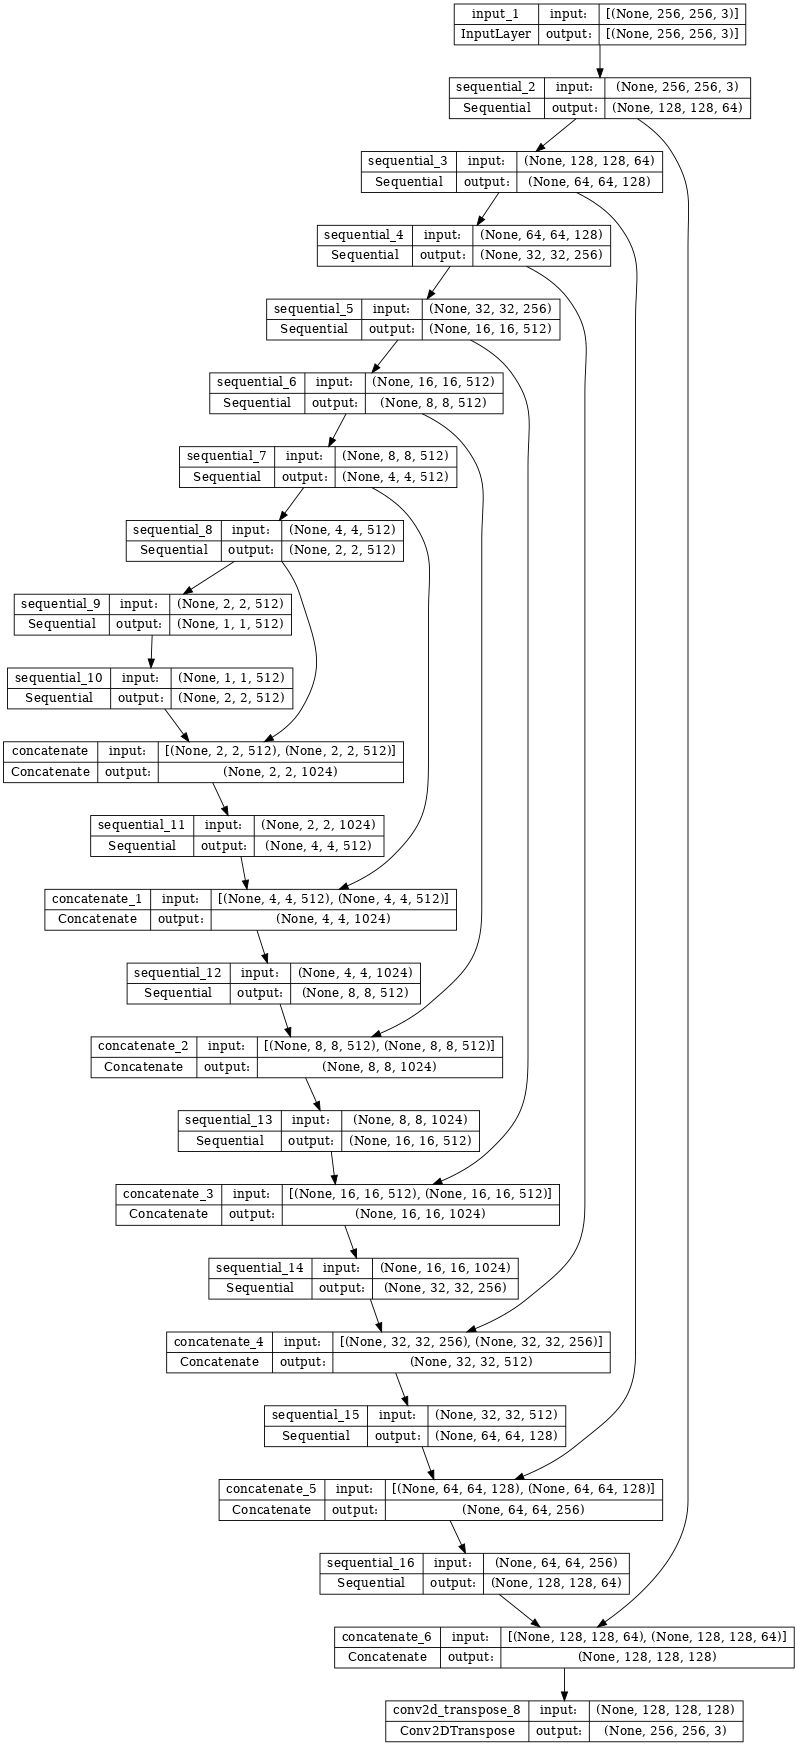

In [26]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

测试生成器：

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


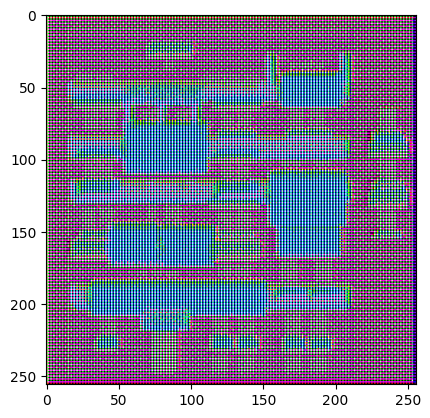

In [27]:
gen_output = generator(inp[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])

### 定义生成器损失

GAN 学习适应数据的损失，而 cGAN 学习结构化损失，该损失会惩罚与网络输出和目标图像不同的可能结构，如 [pix2pix 论文](https://arxiv.org/abs/1611.07004){:.external}中所述。

- 生成器损失是生成图像和**一数组**的 sigmoid 交叉熵损失。
- <a>论文</a>还提到了 L1 损失，它是生成图像与目标图像之间的 MAE（平均绝对误差）。
- 这样可使生成的图像在结构上与目标图像相似。
- 计算总生成器损失的公式为：`gan_loss + LAMBDA * l1_loss`，其中 `LAMBDA = 100`。该值由论文作者决定。

In [28]:
LAMBDA = 100

In [29]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [30]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

生成器的训练过程如下：

![生成器更新图像](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/gen.png?raw=1)


## 构建判别器

pix2pix cGAN 中的判别器是一个卷积 PatchGAN 分类器，它会尝试对每个图像*分块*的真实与否进行分类，如 [pix2pix 论文](https://arxiv.org/abs/1611.07004){:.external}中所述。

- 判别器中的每个块为：Convolution -&gt; Batch normalization -&gt; Leaky ReLU。
- 最后一层之后的输出形状为 `(batch_size, 30, 30, 1)`。
- 输出的每个 `30 x 30` 图像分块会对输入图像的 `70 x 70` 部分进行分类。
- 判别器接收 2 个输入：
    - 输入图像和目标图像，应分类为真实图像。
    - 输入图像和生成图像（生成器的输出），应分类为伪图像。
    - 使用`tf.concat([inp, tar], axis=-1)` 将这 2 个输入连接在一起。

我们来定义判别器：

In [31]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

可视化判别器模型架构：

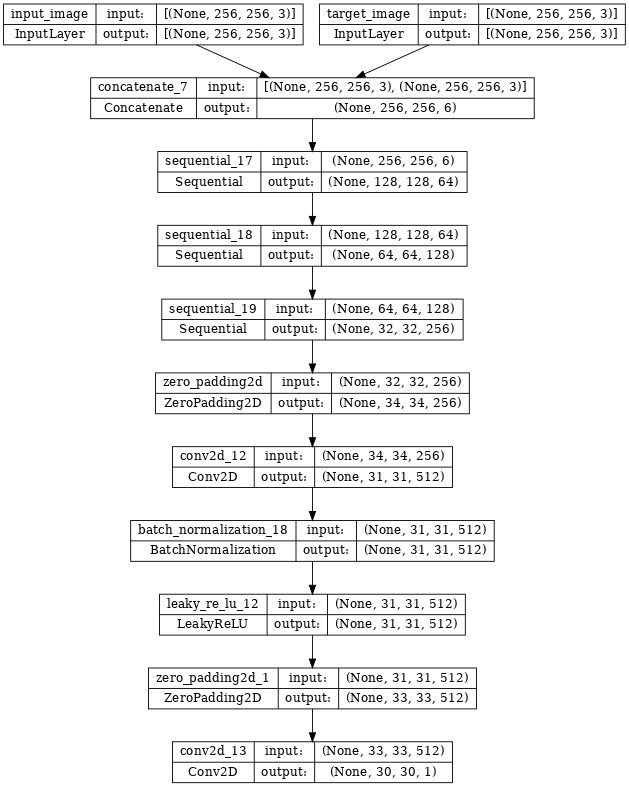

In [32]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

测试判别器：

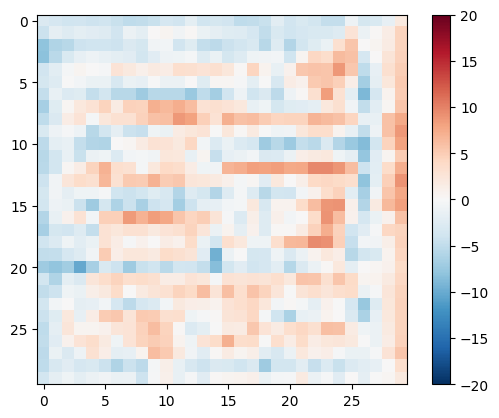

In [33]:
disc_out = discriminator([inp[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

### 定义判别器损失

- `discriminator_loss` 函数接收 2 个输入：**真实图像**和**生成图像**。
- `real_loss` 是**真实图像**和**一组 1的 sigmoid 的交叉熵损失（因为这些是真实图像）**。
- `generated_loss` 是**生成图像**和**一组 0 的 sigmoid 交叉熵损失（因为这些是伪图像）**。
- `total_loss` 是 `real_loss` 和 `generated_loss` 的总和

In [34]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

判别器的训练过程如下所示。

要详细了解架构和超参数，请参阅 [pix2pix 论文](https://arxiv.org/abs/1611.07004){:.external}。

![判别器更新图像](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/dis.png?raw=1)


## 定义优化器和检查点 saver


In [35]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [36]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## 生成图像

编写函数以在训练期间绘制一些图像。

- 将图像从测试集传递到生成器。
- 然后，生成器会将输入图像转换为输出。
- 最后一步是绘制预测，*瞧*！

注：在这里，`training=True` 是有意的，因为在基于测试数据集运行模型时，您需要批次统计信息。如果您使用 training = False，将获得从训练数据集中学习的累积统计信息（您不需要）。

In [37]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

测试该函数：

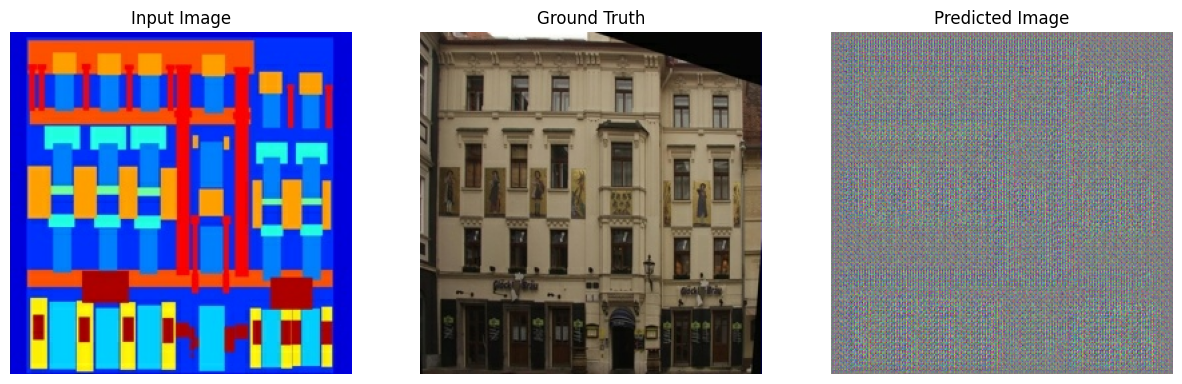

In [38]:
for example_input, example_target in test_dataset.take(1):
  generate_images(generator, example_input, example_target)

## 训练

- 为每个样本输入生成一个输出。
- 判别器接收 input_image 和生成的图像作为第一个输入。第二个输入为 input_image 和 target_image。
- 接下来，计算生成器和判别器损失。
- 随后，计算损失相对于生成器和判别器变量（输入）的梯度，并将其应用于优化器。
- 最后，将损失记录到 TensorBoard。

In [39]:
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [40]:
@tf.function
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
    tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

实际的训练循环。由于本教程可以运行多个数据集，并且数据集的大小差异很大，因此将训练循环设置为按步骤而非按周期工作。

- 迭代步骤数。
- 每 10 步打印一个点 (`.`)。
- 每 1 千步：清除显示并运行 `generate_images` 以显示进度。
- 每 5 千步：保存一个检查点。

In [41]:
def fit(train_ds, test_ds, steps):
  example_input, example_target = next(iter(test_ds.take(1)))
  start = time.time()

  for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
    if (step) % 1000 == 0:
      display.clear_output(wait=True)

      if step != 0:
        print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

      start = time.time()

      generate_images(generator, example_input, example_target)
      print(f"Step: {step//1000}k")

    train_step(input_image, target, step)

    # Training step
    if (step+1) % 10 == 0:
      print('.', end='', flush=True)


    # Save (checkpoint) the model every 5k steps
    if (step + 1) % 5000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

此训练循环会保存日志，您可以在 TensorBoard 中查看这些日志以监控训练进度。

如果您使用的是本地计算机，则需要启动一个单独的 TensorBoard 进程。在笔记本中工作时，请在开始训练之前启动查看器以使用 TensorBoard 进行监控。

To launch the viewer paste the following into a code-cell:

In [ ]:
%load_ext tensorboard
%tensorboard --logdir {log_dir}

最后，运行训练循环：

Time taken for 1000 steps: 92.81 sec



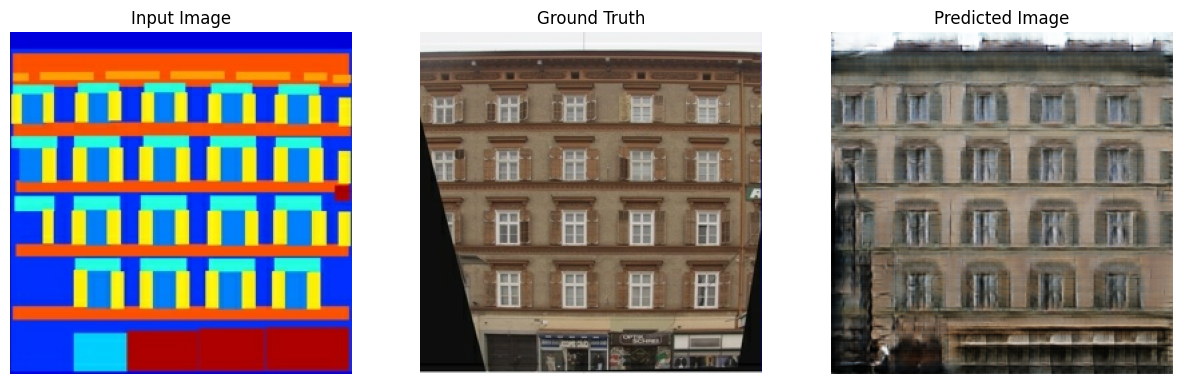

Step: 39k


.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

In [42]:
fit(train_dataset, test_dataset, steps=40000)

如果要*公开*共享 TensorBoard 结果，可以通过将以下代码复制到代码单元中的方式将日志上传到 [TensorBoard.dev](https://tensorboard.dev/)。

注：此操作需要一个 Google 帐号。

```
!tensorboard dev upload --logdir {log_dir}
```

小心：此命令不会终止。它可以连续上传长时间运行实验的结果。数据上传后，您需要使用笔记本工具中的“Interrupt Execution”选项将其停止。

您可以在 [TensorBoard.dev](https://tensorboard.dev/) 上查看此笔记本[先前运行的结果](https://tensorboard.dev/experiment/lZ0C6FONROaUMfjYkVyJqw)。

[TensorBoard.dev](https://tensorboard.dev){:.external} 是一种托管式体验，用于托管、跟踪机器学习实验并与所有人共享。

也可以使用 `<iframe>` 将其包含在行内：

In [43]:
display.IFrame(
    src="https://tensorboard.dev/experiment/lZ0C6FONROaUMfjYkVyJqw",
    width="100%",
    height="1000px")

与简单的分类或回归模型相比，在训练 GAN（或像 pix2pix 这样的 cGAN）时，对日志的解释更加微妙。要检查的内容包括：

- 检查生成器模型或判别器模型均未“获胜”。如果 `gen_gan_loss` 或 `disc_loss` 变得很低，则表明此模型正在支配另一个模型，并且您未能成功训练组合模型。
- 值 `log(2) = 0.69` 是这些损失的一个良好参考点，因为它表示困惑度为 2：判别器对这两个选项的平均不确定性是相等的。
- 对于 `disc_loss`，低于 `0.69` 的值意味着判别器在真实图像和生成图像的组合集上的表现要优于随机数。
- 对于 `gen_gan_loss`，如果值小于 `0.69`，则表示生成器在欺骗判别器方面的表现要优于随机数。
- 随着训练的进行，`gen_l1_loss` 应当下降。

## 恢复最新的检查点并测试网络

In [44]:
!ls {checkpoint_dir}

checkpoint		    ckpt-5.data-00000-of-00001
ckpt-1.data-00000-of-00001  ckpt-5.index
ckpt-1.index		    ckpt-6.data-00000-of-00001
ckpt-2.data-00000-of-00001  ckpt-6.index
ckpt-2.index		    ckpt-7.data-00000-of-00001
ckpt-3.data-00000-of-00001  ckpt-7.index
ckpt-3.index		    ckpt-8.data-00000-of-00001
ckpt-4.data-00000-of-00001  ckpt-8.index
ckpt-4.index


In [45]:
# Restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## 使用测试集生成一些图像

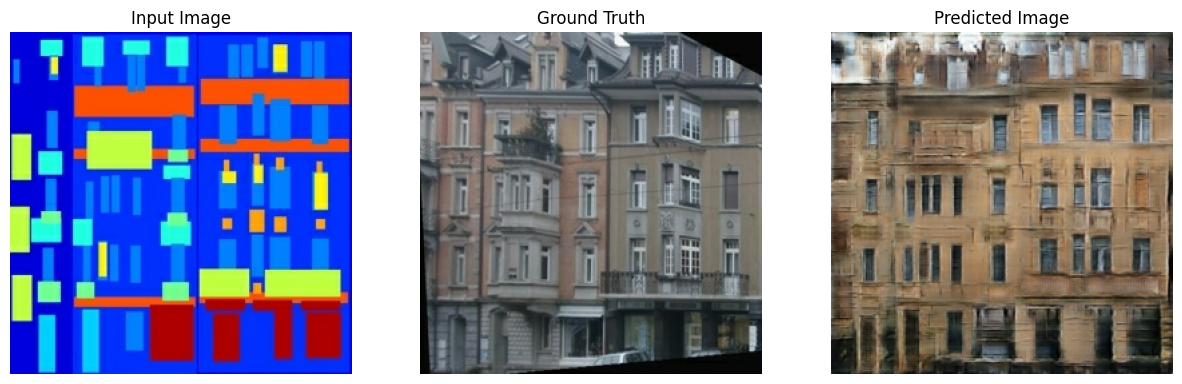

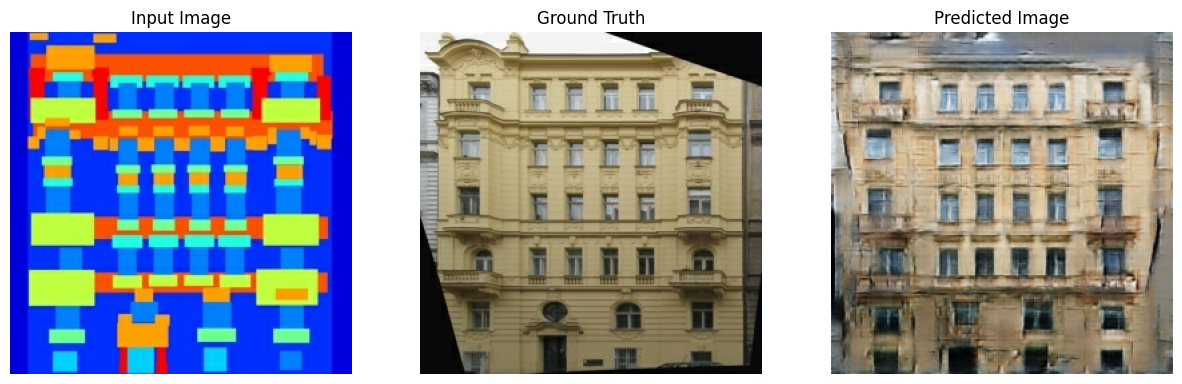

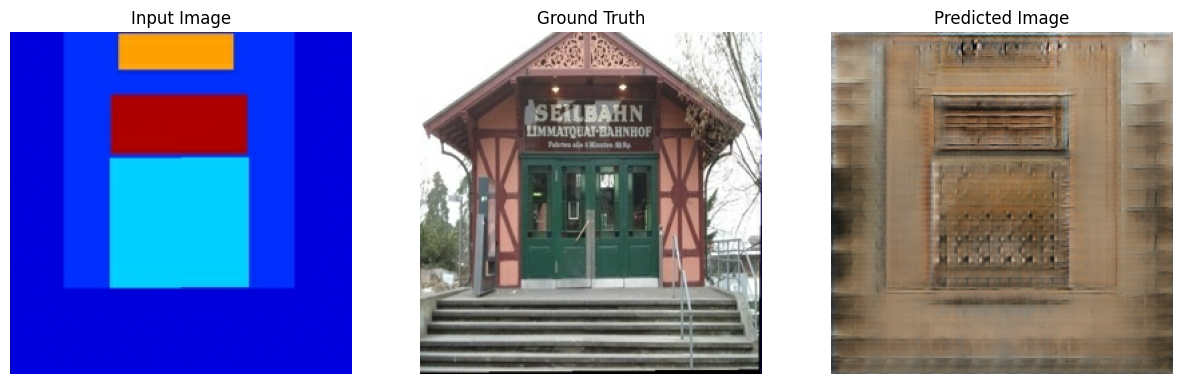

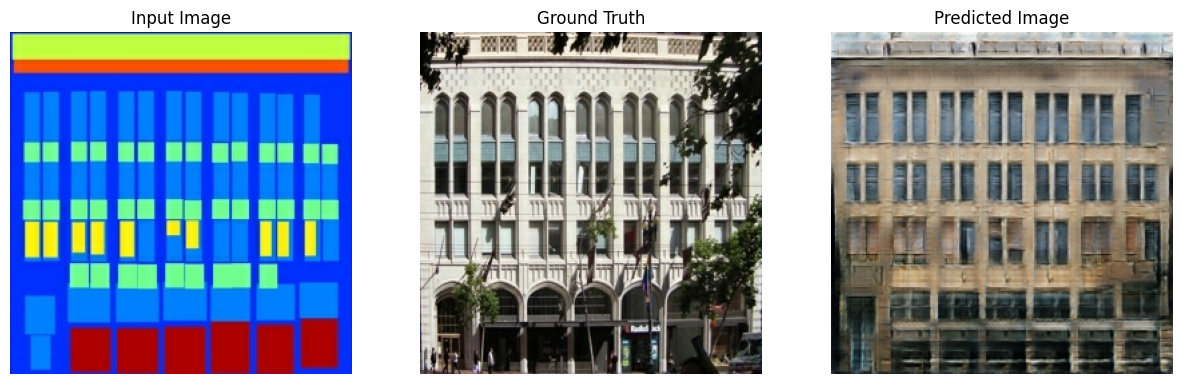

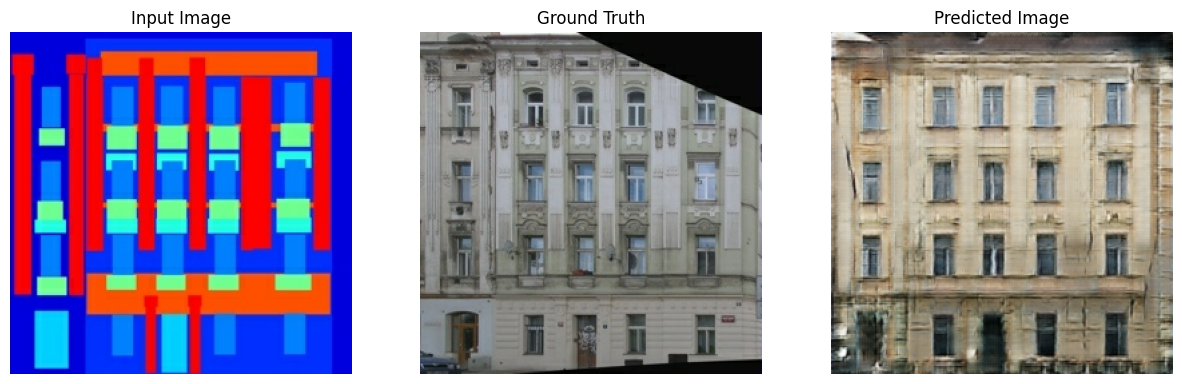

In [46]:
# Run the trained model on a few examples from the test set
for inp, tar in test_dataset.take(5):
  generate_images(generator, inp, tar)